In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 
import scipy.optimize as optimize
import warnings
warnings.filterwarnings("ignore")


In [6]:
# Set i= imaginary number

i   = np.complex(0.0,1.0)

# This class defines puts and calls

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):


    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - Interest rate (constant)
    # tau  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)
        
    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)

    i = np.complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))     
    return value

# Determine coefficients for put prices 

def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value
    
# Black-Scholes call option price

def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    if K is list:
        K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

# Implied volatility method

def ImpliedVolatility(CP,marketPrice,K,T,S_0,r):

    # To determine initial volatility we define a grid for sigma
    # and interpolate on the inverse function

    sigmaGrid = np.linspace(0.0,2.0,1000)
    optPriceGrid = BS_Call_Option_Price(CP,S_0,K,sigmaGrid,T,r)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    print("Initial volatility = {0}".format(sigmaInitial))
    
    # Use already determined input for the local-search (final tuning)

    func = lambda sigma: np.power(BS_Call_Option_Price(CP,S_0,K,sigma,T,r) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, sigmaInitial, tol=1e-10)
    print("Final volatility = {0}".format(impliedVol))
    return impliedVol

def ChFBatesModel(r,tau,kappa,gamma,vbar,v0,rho,xiP,muJ,sigmaJ):
    i = np.complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*\
                               np.exp(-D1(u)*tau)))*(kappa-gamma*rho*i*u-D1(u))

    # Note that we exclude the term -r*tau, as the discounting is already in the COS method

    AHes= lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*\
        rho*i*u-D1(u)) - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    
    A = lambda u: AHes(u) - xiP * i * u * tau *(np.exp(muJ+0.5*sigmaJ*sigmaJ) - 1.0) + \
            xiP * tau * (np.exp(i*u*muJ - 0.5 * sigmaJ * sigmaJ * u * u) - 1.0)
    
    # Characteristic function for the Heston model    

    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 


In [7]:
def mainCalculation():
    CP  = OptionType.CALL
    S0  = 100.0
    r   = 0.00
    
    K = np.linspace(100,200,25)
        
    N = 5000
    L = 5
        
    kappa = 1.1
    gamma = 0.8
    vbar  = 0.05
    rho   = -0.75
    v0    = vbar
    muJ   = 0.0
    sigmaJ= 0.0
    xiP   = 0.2
   
    # Generate implied volatility surface

    plt.figure(1)
    plt.grid()
    plt.xlabel('strike, K')
    plt.xlabel('time-to-mautrity T')
    plt.title('Option price')
    plt.figure(2)
    plt.grid()
    plt.xlabel('strike, K')
    plt.xlabel('time-to-mautrity T')
    plt.title('Implied volatility')
    maturityGrid = np.linspace(1,10,10)
    
    IVM   = np.zeros([len(maturityGrid),len(K)])
    KM    = np.zeros([len(maturityGrid),len(K)])
    TM    = np.zeros([len(maturityGrid),len(K)])
    
    for i in range(0,len(maturityGrid)):
        TM[i,:]         = maturityGrid[i]
        KM[i,:]         = K
    
    for idx, t in enumerate(maturityGrid):    
        cf = ChFBatesModel(r,t,kappa,gamma,vbar,v0,rho,xiP,muJ,sigmaJ)

        # The COS method

        valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, t, K, N, L)

        # Implied volatilities

        for (jdx, k) in enumerate(K):
            IVM[idx,jdx] = ImpliedVolatility(CP,valCOS[jdx],k,t,S0,r)
        plt.figure(1)
        plt.plot(K,valCOS)
        plt.figure(2)
        plt.plot(K,IVM[idx,:])
    
    # Plot the put surface.    

    fig = plt.figure(3)
    ax = fig.gca(projection='3d')
    ax.plot_surface(TM, KM, IVM, color=[1,0.5,1])
    plt.xlabel('T')
    plt.ylabel('K')
    ax.view_init(40, -120)


Initial volatility = [0.17095565]
Final volatility = [0.17095563]
Initial volatility = [0.15506769]
Final volatility = [0.15506789]
Initial volatility = [0.14199176]
Final volatility = [0.14199207]
Initial volatility = [0.13365707]
Final volatility = [0.13365919]
Initial volatility = [0.13030582]
Final volatility = [0.13030753]
Initial volatility = [0.13037251]
Final volatility = [0.13037593]
Initial volatility = [0.13230165]
Final volatility = [0.13230498]
Initial volatility = [0.13514375]
Final volatility = [0.13515703]
Initial volatility = [0.13842918]
Final volatility = [0.13843697]
Initial volatility = [0.14187843]
Final volatility = [0.14188651]
Initial volatility = [0.14534996]
Final volatility = [0.14536885]
Initial volatility = [0.14879189]
Final volatility = [0.14881087]
Initial volatility = [0.1521728]
Final volatility = [0.15217377]
Initial volatility = [0.15541474]
Final volatility = [0.15543791]
Initial volatility = [0.15857675]
Final volatility = [0.15859451]
Initial vol

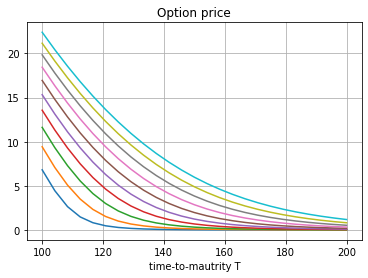

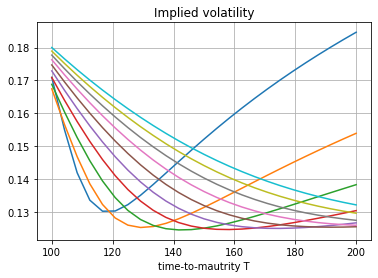

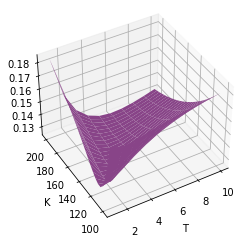

In [8]:
mainCalculation()
